# Helmholtz 1D Multilevel: Constant $k$ + Repetitive Coarsening
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size $a$ and $n_c$ (# principal components) over entire domain. Overlap the last two aggregates if needed.
* Optimize $a, n_c$ to maximize the mock cycle predicted error reduction efficiency.
* 

In [67]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.7

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0
INFO     Iter     |r|                         |x|         RER
INFO     0     1.406e+00                    4.468e-01    3.139
INFO     1     7.628e-01 (0.544) [0.544]    3.342e-01    2.288 (0.728)
INFO     2     4.353e-01 (0.572) [0.558]    2.811e-01    1.561 (0.682)
INFO     3     2.723e-01 (0.627) [0.580]    2.539e-01    1.086 (0.695)
INFO     4     1.864e-01 (0.686) [0.606]    2.380e-01    0.795 (0.732)
INFO     5     1.391e-01 (0.746) [0.632]    2.276e-01    0.622 (0.782)
INFO     6     1.117e-01 (0.803) [0.658]    2.201e-01    0.516 (0.831)
INFO     7     9.389e-02 (0.840) [0.681]    2.144e-01    0.444 (0.863)
INFO     8     8.141e-02 (0.867) [0.702]    2.099e-01    0.393 (0.886)
INFO     9     7.202e-02 (0.884) [0.720]    2.062e-01    0.353 (0.900)
INFO     10    6.475e-02 (0.898) [0.737]    2.030e-01    0.322 (0.912)
INFO     [1.    0.544 0.558 0.58  0.606 0.632 0.658 0.681 0.702 0.72  0.737]
Kac  

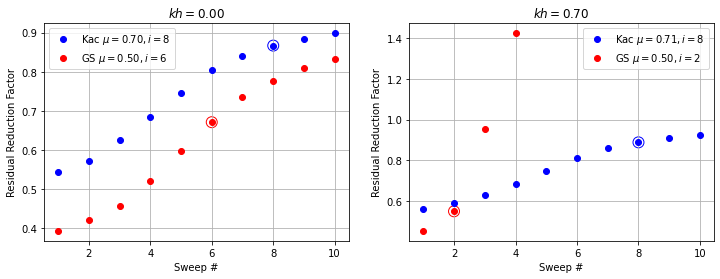

In [69]:
kh_values = [0, kh]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=10, slow_conv_factor=1.1, leeway_factor=leeway_factor)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

### Coarsening: Optimizing $a$, $n_c$

In [70]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
a0 = a
level = hm.setup.hierarchy.create_finest_level(a)

In [71]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a_kh.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     kh 0.7
INFO     Relax at level 0 size 96
INFO     [1.    0.558 0.579 0.599 0.622 0.647 0.671 0.694 0.714 0.733 0.75  0.764 0.778 0.789 0.8   0.809 0.818 0.826 0.833 0.839 0.845]
INFO     Relax conv 0.93 shrinkage 0.65 PODR RER 0.59 after 5 sweeps. Work 1.0 eff 0.65
INFO     Generating TVs with 5 sweeps
INFO     RER 0.634


In [72]:
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 5, dtype=int)
# TODO: determine this based on cycle index.
max_conv_factor = 0.3

coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, aggregate_size_values, nu_values, repetitive=repetitive)
r, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_work, mock_efficiency = \
    coarsener.get_optimal_coarsening(max_conv_factor)
print("kh {:.2f} R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle nu {} conv {:.2f} efficiency {:.2f}".format(
  kh, r.shape, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_efficiency))

kh 0.70 R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.2717; mock cycle nu 2 conv 0.29 efficiency 0.74


In [73]:
info = coarsener.get_coarsening_info(1)
columns=("i", "a", "nc", "cr", "Energy Error", "nu", "conv", "work", "eff")
pd.DataFrame(info).rename(columns=dict(enumerate(columns))).astype(
    {"i": "int32", "a": "int32", "nc": "int32", "nu": "int32"})

,i,a,nc,cr,Energy Error,nu,conv,work,eff
0,0,2,1,0.50,0.47,1,0.64,2.00,0.80
1,0,2,1,0.50,0.47,2,0.35,4.00,0.77
2,0,2,1,0.50,0.47,3,0.24,6.00,0.79
3,0,2,1,0.50,0.47,4,0.26,8.00,0.85
4,1,4,1,0.25,0.61,1,0.86,1.33,0.89
5,1,4,1,0.25,0.61,2,0.86,2.67,0.94
6,1,4,1,0.25,0.61,3,0.89,4.00,0.97
7,1,4,1,0.25,0.61,4,0.83,5.33,0.96
8,2,4,2,0.50,0.27,1,0.63,2.00,0.80
9,2,4,2,0.50,0.27,2,0.29,4.00,0.74


The optimal coarsening (based on mock cycle efficiency) is for a larger aggregate ($4/2$) only for a sufficiently large $kh$, of $\approx 0.7$. Even at $kh = 0.5$, $2/1$ coarsening is (very slightly) better.

### Build Coarse Level: Two-level Bootstrap Cycle

In [74]:
max_levels = 2
num_bootstrap_steps = 1

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood, repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.947 asymptotic RQ -0.008 RER 0.146 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 6 nc 3 cr 0.50 mean_energy_error 0.0975; mock cycle nu 2 conv 0.33 eff 0.76
INFO     Mock cycle conv factor [0.319 0.231 0.168]
INFO     P max error: fit 0.073 val 0.083 test 0.076; alpha mean 0.018
INFO     all  set size 3  P L2 error mean 0.05 max 0.05 A error mean 0.15 max 0.15
INFO     Level 1 size 48
INFO     RER 0.253617
INFO     --------------------------------------------------------------------------------


<!-- ### Interpolation Error -->

In [75]:
# p = multilevel.level[1].p
# r = multilevel.level[1].r
# x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]
# e = x - p.dot(r.dot(x))
# error = norm(e, axis=0) / norm(x, axis=0)
# error_a = norm(level.a.dot(e), axis=0) / norm(x, axis=0)
# print(error_a)
# # print(e[2])
# # print(p[2].todense())
# # print(x[2])

### Level 1 Relaxation Shrinkage Factor

INFO     Iter     |r|                         |x|         RER
INFO     0     2.832e-01                    4.460e-01    0.634
INFO     1     9.064e-02 (0.323) [0.323]    2.331e-01    0.390 (0.618)
INFO     2     4.456e-02 (0.492) [0.398]    1.627e-01    0.278 (0.710)
INFO     3     2.713e-02 (0.610) [0.459]    1.366e-01    0.203 (0.729)
INFO     4     1.899e-02 (0.701) [0.511]    1.238e-01    0.157 (0.776)
INFO     5     1.471e-02 (0.772) [0.555]    1.161e-01    0.129 (0.825)
INFO     6     1.226e-02 (0.829) [0.594]    1.107e-01    0.112 (0.870)
INFO     7     1.074e-02 (0.871) [0.628]    1.066e-01    0.101 (0.904)
INFO     8     9.710e-03 (0.898) [0.657]    1.033e-01    0.094 (0.927)
INFO     9     8.948e-03 (0.917) [0.683]    1.005e-01    0.088 (0.942)
INFO     10    8.353e-03 (0.929) [0.704]    9.797e-02    0.084 (0.953)
INFO     [1.    0.323 0.398 0.459 0.511 0.555 0.594 0.628 0.657 0.683 0.704]
kac   conv 0.93 shrinkage 0.40 PODR RER 0.28 after  2 sweeps. Work  1 efficiency 0.40


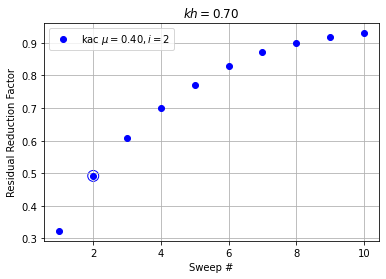

In [76]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=10, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

The coarse-level relaxation is still a good smoother, even though less effective than the fine-level relaxation. This means we built reasonable coarse-level equations that can be solved without advanced relaxation design techniques.

### Relaxation Cycle Shrinkage
We compare a two-level relaxation cycle with $\nu_1=1, \nu_2=1, \nu_{coarse}=$ # relaxations until the coarse-level relaxation slows down, with fine-level Kaczmarz relaxation.

INFO     Iter     |r|                         |x|         RER
INFO     0     1.278e+00                    4.470e-01    2.857
INFO     1     7.191e-01 (0.563) [0.563]    3.380e-01    2.137 (0.746)
INFO     2     4.275e-01 (0.596) [0.579]    2.837e-01    1.520 (0.711)
INFO     3     2.735e-01 (0.641) [0.600]    2.535e-01    1.091 (0.718)
INFO     4     1.921e-01 (0.703) [0.624]    2.345e-01    0.828 (0.760)
INFO     5     1.464e-01 (0.762) [0.650]    2.209e-01    0.670 (0.809)
INFO     6     1.195e-01 (0.816) [0.675]    2.103e-01    0.574 (0.858)
INFO     7     1.020e-01 (0.853) [0.698]    2.016e-01    0.510 (0.890)
INFO     8     8.956e-02 (0.878) [0.719]    1.942e-01    0.465 (0.912)
INFO     9     8.042e-02 (0.897) [0.737]    1.877e-01    0.431 (0.929)
INFO     10    7.333e-02 (0.911) [0.753]    1.819e-01    0.405 (0.940)
INFO     11    6.766e-02 (0.922) [0.767]    1.767e-01    0.385 (0.949)
INFO     12    6.299e-02 (0.930) [0.779]    1.720e-01    0.368 (0.956)
INFO     13    5.905e-0

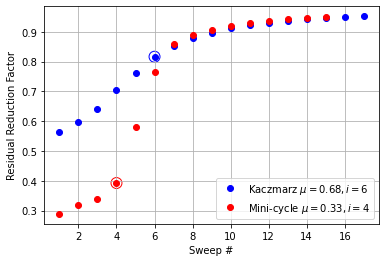

In [77]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=1, nu_post=1, nu_coarsest=nu_coarsest)

#### Observations
* The first cycle increases the residual! Unless enough relaxations (4) are performed at the finest level.
* Convergence is faster than relaxation ($0.4$ vs. $0.6$) until the slowdown.
* The RER at the PODR is a lot smaller than in relaxation.

## Level 1->2 Coarsening

### Two-level Bootstrapping

In [78]:
num_examples = 5
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel1.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.level.append(multilevel1.level[1])

INFO     Relax at level 0 size 48
INFO     [1.    0.358 0.446 0.502 0.548 0.591 0.627 0.658 0.685 0.707 0.726 0.743 0.757 0.771 0.782 0.793 0.802 0.811 0.819 0.826 0.833]
INFO     Relax conv 0.93 shrinkage 0.45 PODR RER 0.27 after 2 sweeps. Work 1.0 eff 0.45
INFO     Generating TVs with 2 sweeps
INFO     RER 0.305
INFO     bootstrap on grid size 48 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.943 asymptotic RQ -0.022 RER 0.050 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (16, 48) a 6 nc 2 cr 0.33 mean_energy_error 0.4238; mock cycle nu 2 conv 0.28 eff 0.65
INFO     Mock cycle conv factor [0.275 0.193 0.155]
INFO     P max error: fit 0.284 val 0.277 test 1.027; alpha mean 0.033
INFO     all  set size 5  P L2 error mean 0.11 max 0.20 A error mean 0.06 max 0.08
INFO     Level 1 size 16
INFO     RER 0.106762
IN

Note that we are now able to reduce the RER of the TVs consisently with bootstrap cycles at level 1.

### Level 2 Relaxation Shrinkage

Level size 16
INFO     Iter     |r|                         |x|         RER
INFO     0     5.218e-02                    4.462e-01    0.117
INFO     1     1.772e-02 (0.344) [0.344]    2.297e-01    0.080 (0.675)
INFO     2     8.258e-03 (0.477) [0.406]    1.617e-01    0.054 (0.686)
INFO     3     5.228e-03 (0.632) [0.476]    1.295e-01    0.042 (0.797)
INFO     4     4.036e-03 (0.770) [0.538]    1.098e-01    0.038 (0.912)
INFO     5     3.345e-03 (0.821) [0.587]    9.496e-02    0.036 (0.952)
INFO     6     2.862e-03 (0.849) [0.626]    8.279e-02    0.035 (0.975)
INFO     7     2.490e-03 (0.866) [0.656]    7.247e-02    0.035 (0.990)
INFO     8     2.177e-03 (0.872) [0.680]    6.355e-02    0.034 (0.994)
INFO     9     1.906e-03 (0.874) [0.700]    5.577e-02    0.034 (0.996)
INFO     10    1.672e-03 (0.876) [0.716]    4.897e-02    0.034 (0.998)
INFO     11    1.467e-03 (0.877) [0.729]    4.301e-02    0.034 (0.999)
INFO     12    1.289e-03 (0.878) [0.741]    3.778e-02    0.034 (1.000)
INFO     

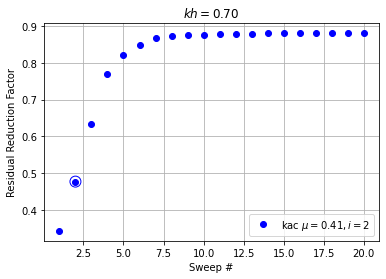

In [79]:
level = multilevel.level[2]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

INFO     Iter     |r|                         |x|         RER
INFO     0     1.204e+00                    4.466e-01    2.698
INFO     1     6.763e-01 (0.562) [0.562]    3.521e-01    1.926 (0.714)
INFO     2     4.006e-01 (0.593) [0.577]    3.064e-01    1.314 (0.682)
INFO     3     2.573e-01 (0.642) [0.599]    2.814e-01    0.921 (0.700)
INFO     4     1.820e-01 (0.707) [0.624]    2.654e-01    0.692 (0.751)
INFO     5     1.399e-01 (0.769) [0.651]    2.537e-01    0.557 (0.805)
INFO     6     1.160e-01 (0.829) [0.678]    2.445e-01    0.479 (0.861)
INFO     7     1.007e-01 (0.868) [0.702]    2.368e-01    0.429 (0.897)
INFO     8     8.994e-02 (0.893) [0.724]    2.301e-01    0.394 (0.920)
INFO     9     8.191e-02 (0.911) [0.742]    2.242e-01    0.369 (0.935)
INFO     10    7.565e-02 (0.923) [0.759]    2.189e-01    0.349 (0.946)
INFO     11    7.061e-02 (0.933) [0.773]    2.141e-01    0.333 (0.954)
INFO     12    6.639e-02 (0.940) [0.786]    2.097e-01    0.319 (0.960)
INFO     13    6.275e-0

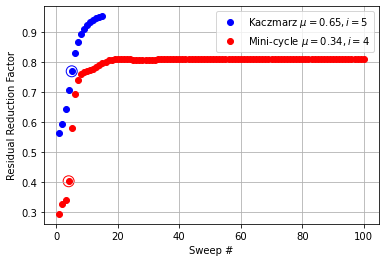

In [80]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, max_sweeps=100,
    nu_pre=1, nu_post=1, nu_coarsest=3)

* Level 2 relaxation behaves weirdly: it slows down after exactly one sweep. One sweep is fast, then the residual reduction goes up, then down, then slowly back up again.
* The Level 1-2 min-cycle is not more efficient.

### Operators

#### Level 0

In [81]:
pd.DataFrame(multilevel.level[0].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01


#### Level 1

In [82]:
pd.DataFrame(multilevel.level[1].a[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.10,-0.19,0.23,-0.05,-0.15,0.21,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.19,-0.13,-0.21,-0.05,-0.15,0.19,0.00,0.00,0.00,0.00,0.00,0.00
2,0.23,-0.21,-0.66,-0.05,-0.17,0.20,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.05,-0.05,-0.05,0.10,-0.19,0.23,-0.05,-0.15,0.21,0.00,0.00,0.00
4,-0.15,-0.15,-0.17,-0.19,-0.13,-0.21,-0.05,-0.15,0.19,0.00,0.00,0.00
5,0.21,0.19,0.20,0.23,-0.21,-0.66,-0.05,-0.17,0.20,0.00,0.00,0.00
6,0.00,0.00,0.00,-0.05,-0.05,-0.05,0.10,-0.19,0.23,-0.05,-0.15,0.21
7,0.00,0.00,0.00,-0.15,-0.15,-0.17,-0.19,-0.13,-0.21,-0.05,-0.15,0.19
8,0.00,0.00,0.00,0.21,0.19,0.20,0.23,-0.21,-0.66,-0.05,-0.17,0.20
9,0.00,0.00,0.00,0.00,0.00,0.00,-0.05,-0.05,-0.05,0.10,-0.19,0.23


In [83]:
pd.DataFrame(multilevel.level[1].p[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.10,-0.38,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.02,-0.58,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.37,-0.50,-0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.57,-0.17,-0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.58,0.27,0.29,0.04,0.07,-0.13,0.00,0.00,0.00,0.00
5,0.35,0.32,0.38,-0.06,-0.09,0.20,0.00,0.00,0.00,0.00
6,0.08,0.12,0.16,-0.10,-0.38,0.49,0.00,0.00,0.00,0.00
7,-0.06,-0.09,-0.10,0.02,-0.58,0.39,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.37,-0.50,-0.19,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.57,-0.17,-0.19,0.00,0.00,0.00,0.00


#### Level 2

In [84]:
pd.DataFrame(multilevel.level[2].a[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.00,0.02,0.08,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.02,-0.06,0.06,0.02,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.08,0.06,-0.00,0.02,0.08,-0.04,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.04,0.02,0.02,-0.06,0.06,0.02,-0.00,-0.00,0.00,0.00,0.00,0.00
4,0.00,-0.00,0.08,0.06,-0.00,0.02,0.08,-0.04,0.00,0.00,0.00,0.00
5,0.00,-0.00,-0.04,0.02,0.02,-0.06,0.06,0.02,-0.00,-0.00,0.00,0.00
6,0.00,0.00,0.00,-0.00,0.08,0.06,-0.00,0.02,0.08,-0.04,0.00,0.00
7,0.00,0.00,0.00,-0.00,-0.04,0.02,0.02,-0.06,0.06,0.02,-0.00,-0.00
8,0.00,0.00,0.00,0.00,0.00,-0.00,0.08,0.06,-0.00,0.02,0.08,-0.04
9,0.00,0.00,0.00,0.00,0.00,-0.00,-0.04,0.02,0.02,-0.06,0.06,0.02


In [85]:
pd.DataFrame(multilevel.level[2].p[:12, :12].todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.48,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.54,-0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.12,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.48,0.11,-0.06,-0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.02,0.51,0.32,-0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-0.26,-0.16,0.11,-0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,-0.13,-0.12,-0.48,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.13,-0.03,-0.54,-0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,-0.04,0.28,-0.12,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.48,0.11,-0.06,-0.19,0.00,0.00,0.00,0.00,0.00,0.00


## How Does the Coarse Variables Look Like?
Print rows of $R_L \cdot \dots \cdot R_1$ and columns of $P_1 \cdot \dots \cdot P_L$ (for $L$ levels of coarsening).

In [86]:
r1 = multilevel.level[1].r
p1 = multilevel.level[1].p

r2 = multilevel.level[2].r
p2 = multilevel.level[2].p

p = p1.dot(p2)
r = r2.dot(r1)

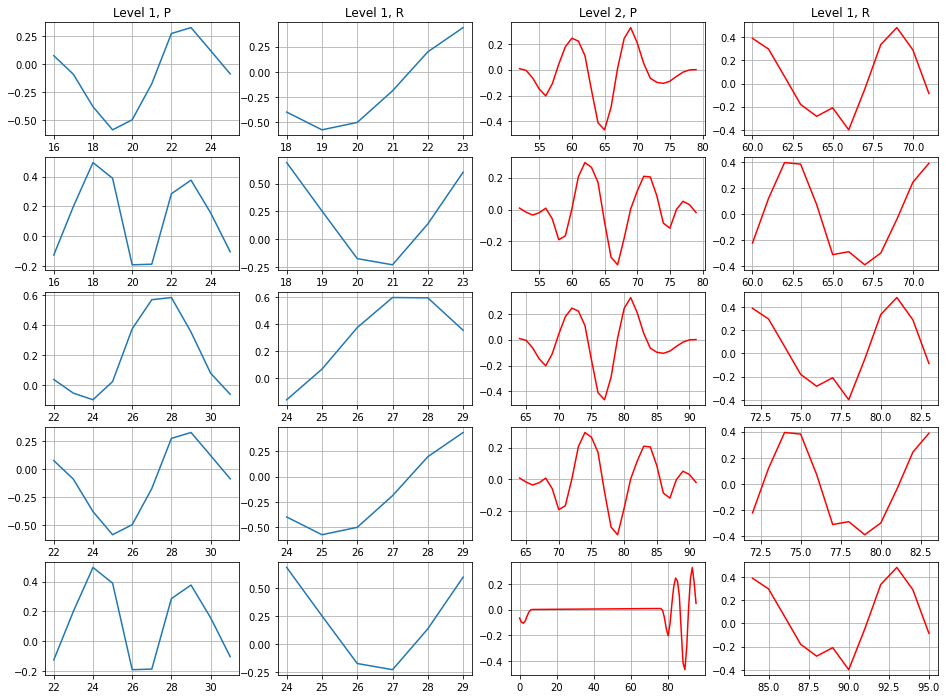

In [87]:
num_vars = 5
fig, axs = plt.subplots(num_vars, 4, figsize=(16, 12))
start_index = 10

col_titles = ("Level 1, P", "Level 1, R", "Level 2, P", "Level 1, R") 
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col)
    
for i in range(num_vars):
    j = start_index + i
    
    ax = axs[i, 0]
    ax.plot(p1[:, j].nonzero()[0], p1[:, j].data)
    ax.grid(True)
    
    ax = axs[i, 1]
    ax.plot(r1[j].nonzero()[1], r1[j].data)
    ax.grid(True)
    
    ax = axs[i, 2]
    ax.plot(p[:, j].nonzero()[0], p[:, j].data, "r")
    ax.grid(True)
    
    ax = axs[i, 3]
    ax.plot(r[j].nonzero()[1], r[j].data, "r")
    ax.grid(True)

The coarse variables ($R$) look like wavelets. The interpolations ($P$) look like a sync, all makes sense.

## Eigenpairs of the Different Level Operators

In [88]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel.level):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel.level)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel.level[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.027 -0.027  0.062  0.062 -0.124 -0.124  0.143  0.143  0.216  0.216 -0.23  -0.23   0.28 ]
1 lam [-0.027 -0.027  0.061  0.061 -0.125 -0.125  0.141  0.141  0.209  0.213 -0.231 -0.231  0.274]
2 lam [-0.026 -0.032 -0.032 -0.06  -0.06   0.069  0.069 -0.113 -0.135 -0.135  0.139  0.139 -0.157]


Looks like the smallest four eigenvalues are well approximated at all levels, to about $10\%$ error.

In [89]:
np.abs(laml[1][:10] - laml[0][:10]) / np.abs(laml[0][:10]), np.abs(laml[2][:10] - laml[0][:10]) / np.abs(laml[0][:10])

(array([0.024, 0.024, 0.021, 0.021, 0.007, 0.007, 0.02 , 0.02 , 0.031, 0.014]),
 array([0.03 , 0.18 , 1.507, 1.957, 0.519, 1.558, 0.516, 1.787, 1.624, 1.624]))

### What Level 1 eigenvectors comprise the level 2 AZM?
We calculate $(v^2_i)^T (R_2 v^1)$, which gives us the spectral decomposition coefficients of the level 2 eigenvector $v^2_i$ in terms of the coarsened level 1 eigenvectors.

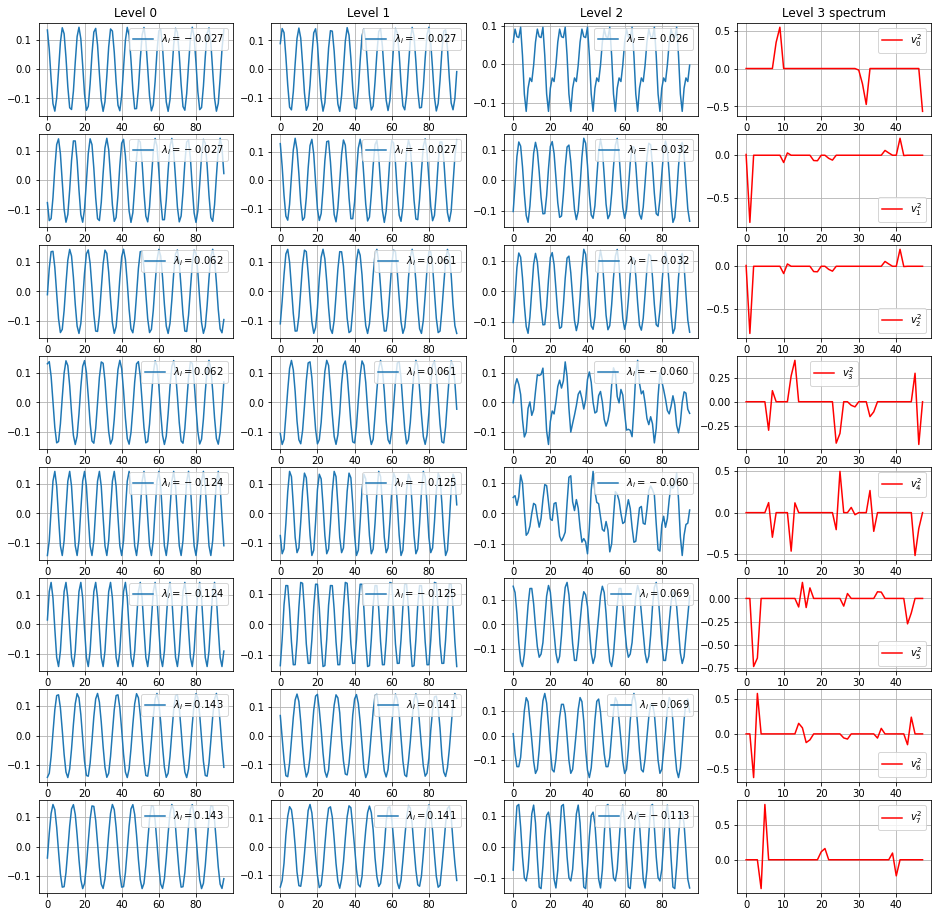

In [90]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl_finest[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(np.real(composition[:, i]), "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

Each level $2$ eigenvecttor corresponds to one level $1$ eigenvector (we don't see the noise introduced by test vectors that vary across the domain here).

In [91]:
## Level 2 -> 3 Coarsening
num_examples = 8
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel2 = hm.hierarchy.multilevel.Multilevel(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel2 = hm.setup.auto_setup.bootstap(
        x, multilevel2, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel2.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.level.append(multilevel2.level[1])

INFO     Relax at level 0 size 16
INFO     [1.    0.403 0.424 0.509 0.567 0.609 0.645 0.672 0.694 0.712 0.727 0.74  0.75  0.76  0.768 0.775 0.781 0.786 0.791 0.796 0.8  ]
INFO     Relax conv 0.88 shrinkage 0.51 PODR RER 0.04 after 3 sweeps. Work 1.0 eff 0.51
INFO     Generating TVs with 3 sweeps
INFO     RER 0.045
INFO     bootstrap on grid size 16 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.597 asymptotic RQ -0.045 RER 0.033 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (9, 16) a 6 nc 3 cr 0.56 mean_energy_error 0.3324; mock cycle nu 2 conv 0.10 eff 0.60
INFO     Mock cycle conv factor [0.115 0.097 0.08 ]
INFO     P max error: fit 0.322 val 0.917 test 1.894; alpha mean 0.500
INFO     all  set size 8  P L2 error mean 0.49 max 0.81 A error mean 0.05 max 0.09
INFO     Level 1 size 9
INFO     RER 0.035867
INFO

### Level 3 Relaxation Shrinkage

Level size 9
INFO     Iter     |r|                         |x|         RER
INFO     0     3.819e-02                    4.449e-01    0.085
INFO     1     1.299e-02 (0.342) [0.342]    3.138e-01    0.041 (0.495)
INFO     2     9.263e-03 (0.753) [0.495]    2.739e-01    0.034 (0.856)
INFO     3     7.466e-03 (0.840) [0.586]    2.525e-01    0.030 (0.908)
INFO     4     6.248e-03 (0.846) [0.643]    2.377e-01    0.027 (0.899)
INFO     5     5.352e-03 (0.857) [0.682]    2.267e-01    0.024 (0.899)
INFO     6     4.662e-03 (0.867) [0.712]    2.184e-01    0.022 (0.901)
INFO     7     4.114e-03 (0.874) [0.735]    2.119e-01    0.020 (0.903)
INFO     8     3.671e-03 (0.882) [0.753]    2.067e-01    0.019 (0.906)
INFO     9     3.309e-03 (0.890) [0.769]    2.024e-01    0.017 (0.911)
INFO     10    3.013e-03 (0.900) [0.782]    1.987e-01    0.016 (0.918)
INFO     11    2.770e-03 (0.912) [0.794]    1.956e-01    0.015 (0.928)
INFO     12    2.569e-03 (0.923) [0.804]    1.928e-01    0.014 (0.938)
INFO     1

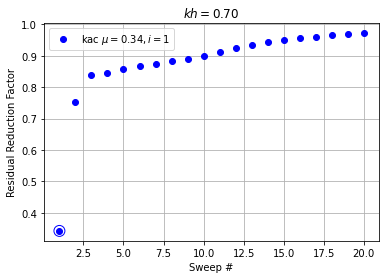

In [92]:
level = multilevel.level[3]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

On this level, relaxation converges quickly, so we can stop coarsening.

# Test Multilevel Cycle Convergence

### Solving $A x = 0$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed domain. Starting from random. Even solving exactly on the coarsest level works here.

In [93]:
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, num_levels=3, debug=True).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((multilevel.level[0].size, )), 8, print_frequency=1)

INFO         0 |r| 8.448e+00 RER 1.56590
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            8.6221e-01    1.5659e+00
INFO     0        relax 1            5.0968e-01    1.0289e+00
INFO     1        initial            3.4103e-01    5.0211e-01
INFO     1        relax 1            1.1131e-01    3.9980e-01
INFO     2        initial            6.5968e-02    2.1035e-01
INFO     2        coarsest           2.5906e-17    3.3338e-17
INFO     1        correction         1.7294e-01    4.4845e-01
INFO     1        relax 1            1.1176e-01    3.9198e-01
INFO     0        correction         4.3356e-01    1.8957e+00
INFO     0        relax 1            2.5109e-01    1.2390e+00
INFO         1 |r| 2.460e+00 (0.29122) RER 1.23903 (0.79126) 1.986
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation   

In [94]:
for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((a0.shape[0], )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

V(1, 1) conv factor 6.540
V(2, 1) conv factor 5.956
V(3, 1) conv factor 5.171
V(4, 1) conv factor 4.455


### Solving $Ax = b$
Works the same way as for $Ax = 0$.

In [95]:
# Random RHS.
b = np.random.random((a0.shape[0], ))

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO         0 |r| 8.949e+00 RER 1.56672
INFO         1 |r| 4.750e+00 (0.53076) RER 0.07394 (0.04720) 64.236
INFO         2 |r| 2.637e+01 (5.55165) RER 0.07396 (1.00020) 356.548
INFO         3 |r| 1.710e+02 (6.48542) RER 0.07190 (0.97216) 2378.593
INFO         4 |r| 1.121e+03 (6.55518) RER 0.07228 (1.00536) 15508.962
INFO         5 |r| 7.328e+03 (6.53652) RER 0.07221 (0.99904) 101471.705
INFO         6 |r| 4.793e+04 (6.54079) RER 0.07223 (1.00018) 663586.724
INFO         7 |r| 3.134e+05 (6.53983) RER 0.07222 (0.99997) 4339889.224
INFO         8 |r| 2.050e+06 (6.54004) RER 0.07222 (1.00001) 28382857.143
INFO         9 |r| 1.341e+07 (6.53999) RER 0.07222 (1.00000) 185623915.379
INFO        10 |r| 8.768e+07 (6.54000) RER 0.07222 (1.00000) 1213980563.726
INFO        11 |r| 5.734e+08 (6.54000) RER 0.07222 (1.00000) 7939433787.566
INFO        12 |r| 3.750e+09 (6.54000) RER 0.07222 (1.00000) 51923903225.930
INFO        13 |r| 2.453e+10 (6.54000) RER 0.07222 (1.00000) 339582367299.844
INFO    

### Solving $A x = \lambda x$
Work in progress.

In [96]:
# level = multilevel.finest_level
# lam = 0

# eigen_cycle = lambda x, lam: hm.setup_eigen.eigensolver.eigen_cycle(multilevel, 1.0, 1, 1, 100, debug=True).run((x, lam))
# # FMG start so (x, lambda) has a reasonable initial guess.
# #x = hm.setup_eigen.bootstrap_eigen.fmg(multilevel, num_cycles_finest=0)
# x = np.random.random((a0.shape[0], 1))
# x, lam, conv_factor = hm.solve.run.run_iterative_eigen_method(level.operator, eigen_cycle, x, lam, 20, print_frequency=1)

## Automating the Entire Setup Phase
Looks like the process is sensitive in two ways depending on the random seed (used to generate the initial TV at each level):
* We might not find a good coarsening whose mock cycle rate < $0.4$ (the maximum allowed).
* We might have too many interpolation points and not enough windows/test vectors. Especially if we coarsen by 6/4 at some point (that's because we do not yet truncate small $P$ weight).
* The ML cycle may strongly diverge because of a particular level.
* The domain size may not be divisible by the the aggregate size. $R$ can be periodic with an overlapping aggregate, but $P$ cannot be.

### A Happy Case

In [97]:
np.random.seed(0)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO     [1.    0.565 0.578 0.6   0.627 0.654 0.68  0.704 0.725 0.744 0.76  0.774 0.786 0.797 0.807 0.815 0.823 0.83  0.837 0.843 0.848]
INFO     level 0 size 96 relax conv 0.95 shrinkage 0.73 PODR RER 0.45 after 8 sweeps. Work 1.0 eff 0.73
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.389
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.925 asymptotic RQ 0.015 RER 0.113 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0398; mock cycle nu 2 conv 0.32 eff 0.75
INFO     Mock cycle conv factor [0.315 0.184 0.122]
INFO     P max error: fit 0.056 val 0.031 test 0.069; alpha mean 0.000
INFO     all  set size 2  P L

### Case of Slow Solution Cycle

In [98]:
np.random.seed(2)

multilevel = hm.setup.auto_setup.setup(a0, repetitive=repetitive, leeway_factor=leeway_factor)
print ("#levels", len(multilevel.level))

# Solve Ax=0.
b = np.zeros((a0.shape[0], ))
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 1, rhs=b, num_levels=3).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(lambda x: b - multilevel.level[0].operator(x), two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

INFO     [1.    0.566 0.58  0.601 0.626 0.654 0.681 0.706 0.727 0.746 0.762 0.776 0.788 0.799 0.809 0.818 0.826 0.833 0.839 0.845 0.851]
INFO     level 0 size 96 relax conv 0.96 shrinkage 0.73 PODR RER 0.41 after 8 sweeps. Work 1.0 eff 0.73
INFO     ================================================================================
INFO     Coarsening level 0->1
INFO     Generating 2 TV with 8 sweeps
INFO     RER 0.402
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.920 asymptotic RQ -0.052 RER 0.150 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0832; mock cycle nu 3 conv 0.18 eff 0.75
INFO     Mock cycle conv factor [0.318 0.186 0.126]
INFO     P max error: fit 0.043 val 0.042 test 0.119; alpha mean 0.005
INFO     all  set size 2  P 

Exception: Could not find a coarsening whose mock cycle is below 0.40

### Dependence on $kh$
$kh = 0.5$ is supposedly the hardest case. Here it works with the same efficiency as $kh = 0.7$.

In [ ]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

np.random.seed(0)
multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                      max_levels=3)
print ("#levels", len(multilevel.level))

for nu in range(1, 5):
    two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
    _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((a0.shape[0], )), 20)
    print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

### Dependence on Problem Size
Convergence degrades with increasing size at the moment. Sometimes the cycle completely diverges.

In [ ]:
kh = 0.5
for n in 96 * 2 ** np.arange(4):
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

    np.random.seed(2)
    multilevel = hm.setup.auto_setup.setup(a, repetitive=repetitive, leeway_factor=leeway_factor,
                                          max_levels=3)
    print("n", n, "#levels", len(multilevel.level))

    for nu in range(1, 5):
        two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 1).run(x)
        _, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, np.random.random((multilevel.level[0].size, )), 20)
        print("V({}, {}) conv factor {:.3f}".format(nu, 1, conv_factor))

## Level 1 Cycle Convergence Test

In [ ]:
m1 = multilevel
print(len(multilevel))
m1.level = multilevel.sub_hierachy(1)
sz = m1.level[0].size

np.random.seed(0)
x0 = np.random.random((sz, ))
b = m1.level.operator(x0)

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(m1, 1.0, 1, 1, rhs=b, num_levels=2, debug=True).run(x)
x, conv_factor = hm.solve.run.run_iterative_method(m1.level[0].operator, two_level_cycle, np.random.random((sz, )), 8, print_frequency=1)
plt.plot(x)

In [ ]:
len(multilevel.level)

In [ ]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel.level):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel.level)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel.level[k].p.dot(v)
    vl_finest.append(v)

In [ ]:
len(multilevel.level)

In [ ]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(np.real(vl_finest[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(np.real(composition[:, i]), "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

In [ ]:
pd.DataFrame(multilevel.level[2].p.todense())

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, max_sweeps=20,
    nu_pre=1, nu_post=1, num_levels=2, nu_coarsest=3, slow_conv_factor=0.95)

In [ ]:
m1.level[1].size